# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("datasets/X_train.txt")
y_train = np.loadtxt("datasets/y_train.txt").astype(int)

X_test = np.loadtxt("datasets/X_test.txt")
y_test = np.loadtxt("datasets/y_test.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
X =X = np.vstack([X_train, X_test])  # np.vstack вертикально объединяет
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)  #фиксируем random_state (константа RANDOM_STATE).

X_pca = pca.fit_transform(X_scaled)


print(f"Объяснённая дисперсия: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum() * 100:.2f}%)")

Объяснённая дисперсия: 0.9005 (90.05%)


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

**65**

In [9]:
# Ваш код здесь
print(f"Число компонент, объясняющих ≥90% дисперсии: {pca.n_components_}")

Число компонент, объясняющих ≥90% дисперсии: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

**51**

In [10]:
rounded_pct_percent = round(pca.explained_variance_ratio_[0] * 100)
print(rounded_pct_percent)

51


Визуализируйте данные в проекции на первые две главные компоненты.

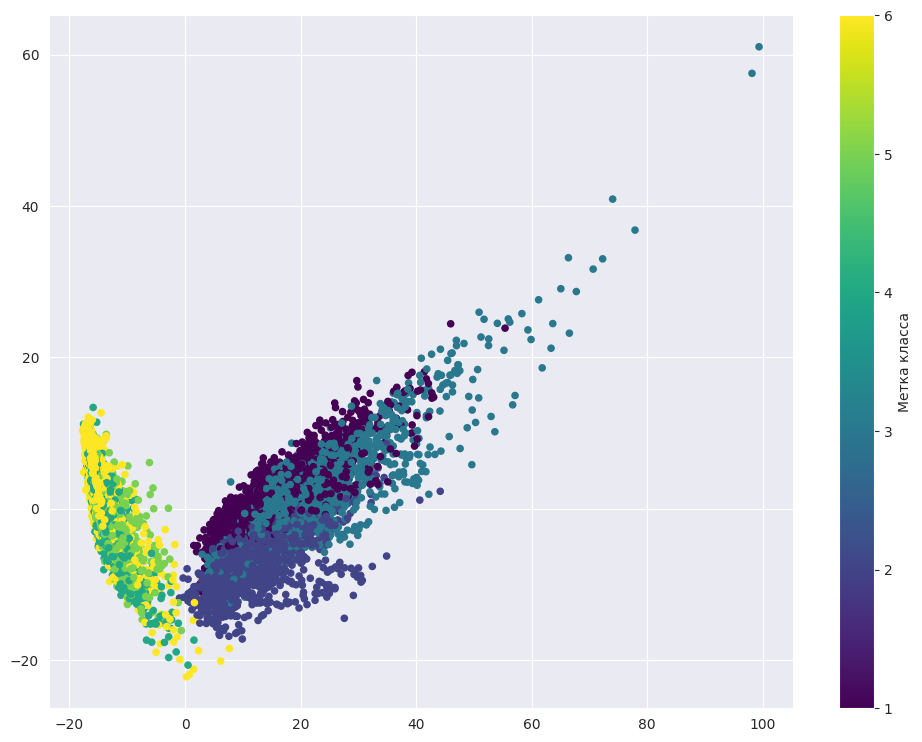

In [11]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar(label='Метка класса')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
from sklearn.cluster import KMeans
kmeans_sklearn = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_sklearn.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

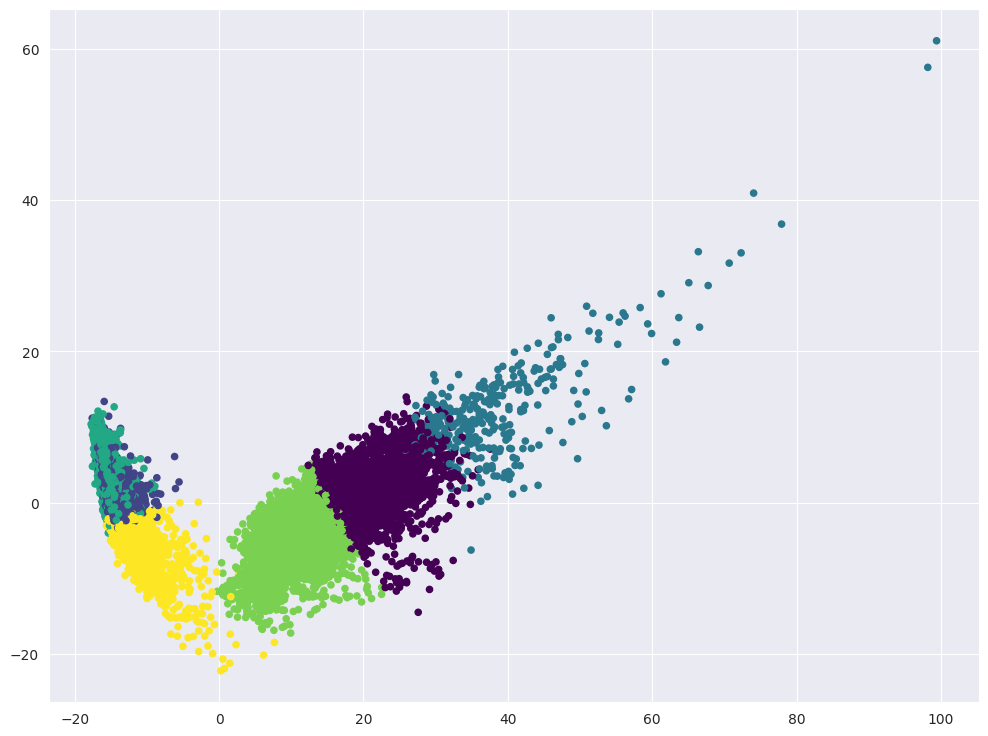

In [13]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,740,0,85,0,897,0,1722
подъем вверх по лестнице,295,0,9,0,1238,2,1544
спуск по лестнице,883,0,214,0,309,0,1406
сидение,0,1235,0,91,1,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,0,52,0,1558,5,329,1944
все,1918,2631,308,1649,2450,1343,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

**перечисленные варианты не подходят**

In [16]:
tab_clean = tab.iloc[:-1, :-1]
max_ratios = tab_clean.max(axis=1) / tab_clean.sum(axis=1)
max_ratios = max_ratios.round(3)
print(max_ratios)

ходьба                      0.521
подъем вверх по лестнице    0.802
спуск по лестнице           0.628
сидение                     0.695
стояние                     0.705
лежание                     0.801
dtype: float64


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

C:\Users\Aly\AppData\Local\Temp\ipykernel_7036\4238759512.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

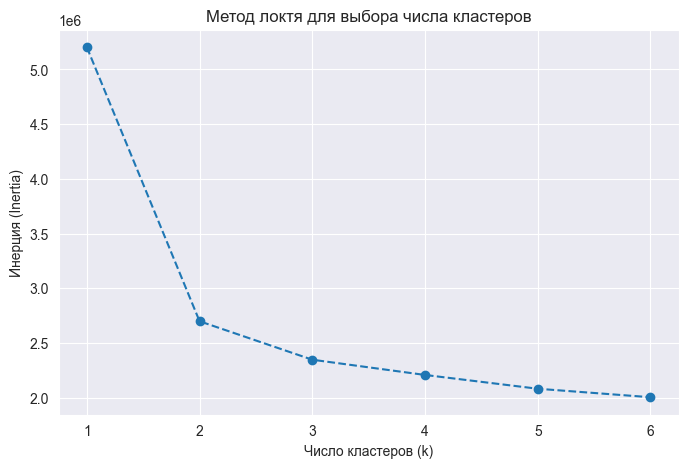

In [17]:
n_classes = 6
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)  # сохраняем сумму квадратов расстояний до центроидов
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_classes + 1), inertia, marker='o', linestyle='--')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Инерция (Inertia)')
plt.title('Метод локтя для выбора числа кластеров')
plt.grid(True)
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

**2**

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [18]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [19]:
from sklearn.metrics import adjusted_rand_score

# Метки от KMeans (должны быть получены ранее)
# Если ещё не получены — раскомментируйте:
# from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=10)
labels_kmeans = kmeans.fit_predict(X_pca)

# Метки от Agglomerative Clustering (у вас уже есть `ag`)
labels_agglo = ag.labels_  # или ag.fit_predict(X_pca)

# Считаем ARI
ari_kmeans = adjusted_rand_score(y, labels_kmeans)
ari_agglo  = adjusted_rand_score(y, labels_agglo)

# Выводим результаты
print(f"Adjusted Rand Index (KMeans):      {ari_kmeans:.4f}")
print(f"Adjusted Rand Index (Agglomerative): {ari_agglo:.4f}")

Adjusted Rand Index (KMeans):      0.4201
Adjusted Rand Index (Agglomerative): 0.4936


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

**все**


**все**

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [20]:
# Создаём и обучаем StandardScaler ТОЛЬКО на обучающей выборке
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # обучение + трансформация
X_test_scaled = scaler.transform(X_test)

In [25]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000,  dual=False)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(svc, svc_params , cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

,estimator,LinearSVC(dua...ndom_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [26]:
# Ваш код здесь
best_svc = grid_search.best_estimator_
test_score = best_svc.score(X_test_scaled, y_test)
print(f"Точность на тесте: {test_score:.4f}")

Точность на тесте: 0.9620


In [ ]:
# Ваш код здесь

**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

**0.1**

In [27]:
y_predicted = best_svc.predict(X_test_scaled)

In [28]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

**по точности – сидение, по полноте – стояние** (но код дает другой ответ такого варианта нет)

In [36]:
y_true = np.array(y_test) - 1
y_pred = np.array(y_predicted) - 1

n_classes = 6
conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
np.add.at(conf_matrix, (y_true, y_pred), 1)
class_names = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
               'сидение', 'стояние', 'лежание']

tp = np.diag(conf_matrix)
fp = conf_matrix.sum(axis=0) - tp
fn = conf_matrix.sum(axis=1) - tp

precision = tp / (tp + fp + 1e-12)
recall = tp / (tp + fn + 1e-12)

print("Точность по классам:")
for i, name in enumerate(class_names):
    print(f"  {name}: {precision[i]:.4f}")

print("\nПолнота по классам:")
for i, name in enumerate(class_names):
    print(f"  {name}: {recall[i]:.4f}")

worst_precision_idx = np.argmin(precision)
worst_recall_idx = np.argmin(recall)

print(f"\nХуже всего по точности: {class_names[worst_precision_idx]} ({precision[worst_precision_idx]:.4f})")
print(f"Хуже всего по полноте:   {class_names[worst_recall_idx]} ({recall[worst_recall_idx]:.4f})")

Точность по классам:
  ходьба: 0.9724
  подъем вверх по лестнице: 0.9787
  спуск по лестнице: 1.0000
  сидение: 0.9638
  стояние: 0.8778
  лежание: 1.0000

Полнота по классам:
  ходьба: 0.9960
  подъем вверх по лестнице: 0.9745
  спуск по лестнице: 0.9833
  сидение: 0.8676
  стояние: 0.9718
  лежание: 0.9795

Хуже всего по точности: стояние (0.8778)
Хуже всего по полноте:   сидение (0.8676)


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [34]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svc = LinearSVC(random_state=RANDOM_STATE, max_iter=3000, dual=False)
grid_pca = GridSearchCV(svc, {'C': [0.001, 0.01, 0.1, 1, 10]}, cv=3, scoring='accuracy')
grid_pca.fit(X_train_pca, y_train)

best_score_full = grid_search.best_score_
best_score_pca  = grid_pca.best_score_

diff_percent = abs(best_score_full - best_score_pca) * 100
print(f"Разность: {diff_percent:.2f}%  округление: {round(diff_percent)}%")

Разность: 3.96% → округление: 4%


**4%**

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**2 и 3
PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)  # (n_samples, 2)

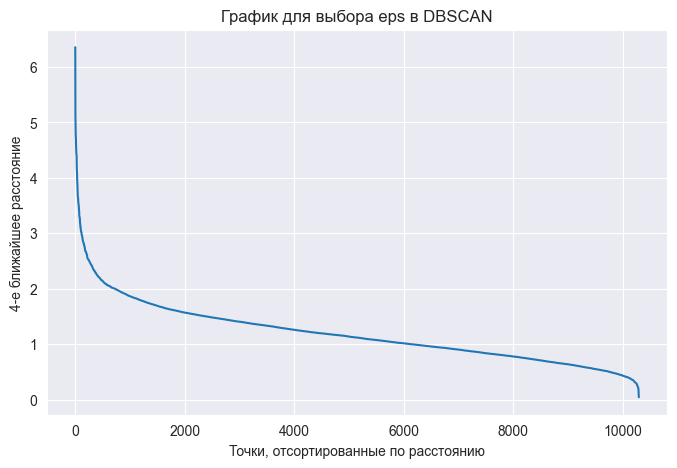

In [44]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_tsne)
distances, indices = nbrs.kneighbors(X_tsne)
distances = np.sort(distances[:, 4], axis=0)[::-1]

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel('Точки, отсортированные по расстоянию')
plt.ylabel('4-е ближайшее расстояние')
plt.title('График для выбора eps в DBSCAN')
plt.grid(True)
plt.show()

In [45]:
from sklearn.cluster import DBSCAN

# Подберём eps (на основе расстояний) eps: 1.8 – 2.2
dbscan = DBSCAN(eps=1.9, min_samples=5)
cluster_labels_dbscan = dbscan.fit_predict(X_tsne)

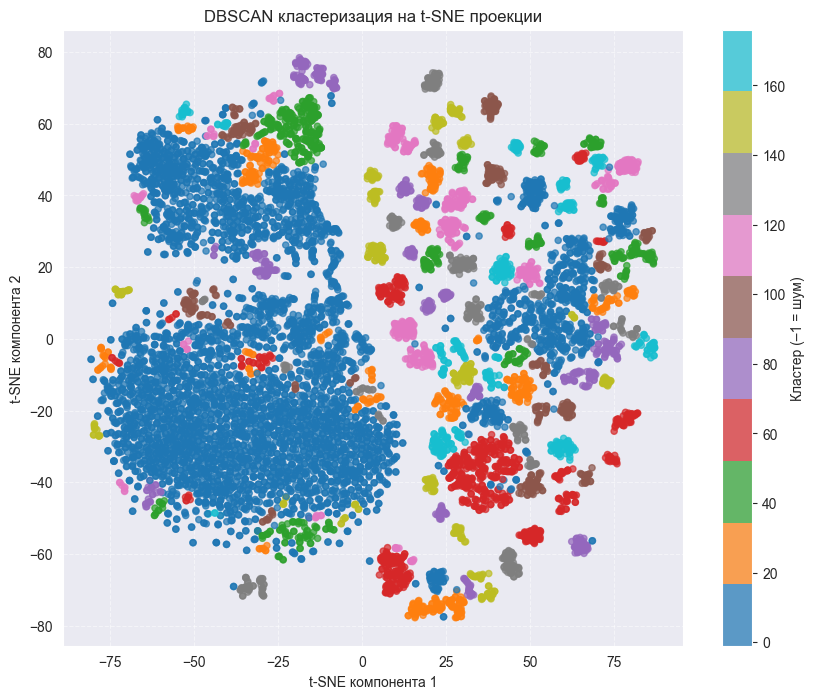

In [46]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=cluster_labels_dbscan,
    cmap='tab10',
    s=20,
    alpha=0.7
)
plt.title('DBSCAN кластеризация на t-SNE проекции')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.colorbar(scatter, label='Кластер (–1 = шум)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()